# CLASIFICAR ggF y VBF CON MACHINE LEARNING

## PAQUETES

In [1]:
# dataframes 
import numpy as np
import pandas as pd

# cargar archivos
import uproot
from tqdm import tqdm # sirve para ver la linea de carga al cargar los archivos
import sys
import yaml

# gráficos
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

# funciones creadas
from lectura import *
from formulas import *
from cortes import *
from graficar import *
from metricas import *

# para hacer matriz confusion
from sklearn.metrics import confusion_matrix

# para recargar los modulos mientras los voy debugeando
%load_ext autoreload
%autoreload 2

# MAIN

In [2]:
########################################################
########### LECTURA DATOS PREVIOS YAML #################
########################################################

# cargar archivo yaml
path = "/home/tomilee/Desktop/Universidad/dark_photons/proyecto_investigacion/codigo/"
data_yaml = read_data_yaml('parametros_cortes.yaml')      #Parámetros del calo

# de data_yaml obtenemos los nombres de los datasets
vbf_data = data_yaml['VBF'].values() #esto devuelve solo los valores de cada variable.
ggf_data = data_yaml['ggF'].values() #esto devuelve solo los valores de cada variable.

# de data_yaml obtenemos los nombres de las variables
variables = data_yaml['recover_branches']
# de data_yaml obtenemos las escalas de las variables
scales = data_yaml['scale_variable']

# de data_yaml obtenemos los nombres de los cortes y los valores de los cortes menores y mayores
cuts = data_yaml['cuts']

In [3]:
########################################################
############# LECTURA DATOS ROOT FILES #################
########################################################
df_all = read_datasets(vbf_data, ggf_data, variables, scales, path)
df_all

  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:00<00:01,  4.25it/s]

samples/VBF/frvz_vbf_500757


 25%|██▌       | 2/8 [00:00<00:01,  4.42it/s]

samples/VBF/frvz_vbf_500758


 38%|███▊      | 3/8 [00:00<00:01,  4.50it/s]

samples/VBF/frvz_vbf_500759


 50%|█████     | 4/8 [00:00<00:00,  4.54it/s]

samples/VBF/frvz_vbf_500760


 62%|██████▎   | 5/8 [00:01<00:00,  4.55it/s]

samples/VBF/frvz_vbf_500761


 75%|███████▌  | 6/8 [00:01<00:00,  4.54it/s]

samples/VBF/frvz_vbf_500762


 88%|████████▊ | 7/8 [00:01<00:00,  4.55it/s]

samples/VBF/frvz_vbf_500763


100%|██████████| 8/8 [00:01<00:00,  4.52it/s]


samples/VBF/frvz_vbf_500764


100%|██████████| 9/9 [00:02<00:00,  3.07it/s]


njet30           mjj            MET  \
origin df_name                                                            
VBF    samples/VBF/frvz_vbf_500757       2  1.316194e+06  177043.093750   
       samples/VBF/frvz_vbf_500757       7  2.287880e+06  101195.085938   
       samples/VBF/frvz_vbf_500757       2  1.568506e+06  130909.734375   
       samples/VBF/frvz_vbf_500757       4  4.717408e+05  491291.656250   
       samples/VBF/frvz_vbf_500757       8  1.150060e+06  115439.734375   
...                                    ...           ...            ...   
ggF    samples/ggF/frvz_ggf_508893       1 -9.990000e+02   40554.480469   
       samples/ggF/frvz_ggf_508893       3  2.406892e+05   76802.445312   
       samples/ggF/frvz_ggf_508893       2  1.434225e+05   26644.656250   
       samples/ggF/frvz_ggf_508893       0 -9.990000e+02   10709.070312   
       samples/ggF/frvz_ggf_508893       0 -9.990000e+02   10808.947266   

                                    scale1fb    intLumi  
origin df_name                                           
VBF    samples/VBF/frvz_vbf_500757  0.000486  44.299999  
       samples/VBF/frvz_vbf_500757  0.000502  44.299999  
       samples/VBF/frvz_vbf_500757  0.000429  44.299999  
       samples/VBF/frvz_vbf_500757  0.000531  44.299999  
       samples/VBF/frvz_vbf_500757  0.000014  44.299999  
...                                      ...        ...  
ggF    samples/ggF/frvz_ggf_508893  0.028479  58.450001  
       samples/ggF/frvz_ggf_508893  0.029882  58.450001  
       samples/ggF/frvz_ggf_508893  0.029517  58.450001  
       samples/ggF/frvz_ggf_508893  0.029929  58.450001  
       samples/ggF/frvz_ggf_508893  0.030318  58.450001  

[4628576 rows x 5 columns]

In [64]:
#################################################################
#################### PROCESAMIENTO DE DATOS #####################
#################################################################

# hago los cortes definitivos
df_all_cut = do_cuts(df_all, cuts, scales)

# modifico df_all para aplicar ml
df_cortes = df_all_cut
df_cortes = df_cortes.droplevel('df_name')
df_cortes = df_cortes.drop(['njet30', 'scale1fb', 'intLumi'], axis=1) # omito njet30, intlumi y scale1f
df_cortes = df_cortes.reset_index(level='origin')
df_cortes = pd.get_dummies(df_cortes, columns=['origin'], dtype=int)

# creo los 2 filtros para vbf, si ambos son ciertos, es vbf (1) si no, no es vbf (0)
# filtro_MET = df_cortes["MET"] >= 225000
filtro_mjj = df_cortes["mjj"] >= 1000000
# filtro_mjj = df_cortes["mjj"] >= 728000
# df_cortes['pred_VBF'] = np.where(filtro_MET & filtro_mjj, 1, 0)
df_cortes['pred_VBF'] = np.where(filtro_mjj, 1, 0)

df_cortes

Numero eventos antes: 4628576
Corte: njet30 entre [1, inf]
Numero eventos despues: 2013265 



,mjj,MET,origin_VBF,origin_ggF,pred_VBF
0,1.316194e+06,177043.093750,1,0,1
1,2.287880e+06,101195.085938,1,0,1
2,1.568506e+06,130909.734375,1,0,1
3,4.717408e+05,491291.656250,1,0,0
4,1.150060e+06,115439.734375,1,0,1
...,...,...,...,...,...
2012571,8.682021e+04,36471.000000,0,1,0
2012572,6.930484e+04,5845.552246,0,1,0
2012573,5.065558e+05,27214.392578,0,1,0
2012574,2.406892e+05,76802.445312,0,1,0


In [65]:
matriz = confusion(df_cortes["origin_VBF"], df_cortes["pred_VBF"])

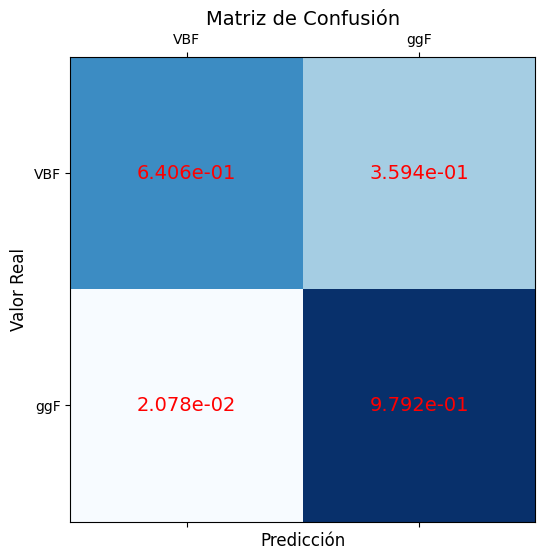

In [66]:
plot_matriz(matriz, porcentaje = False, normalizado=True)

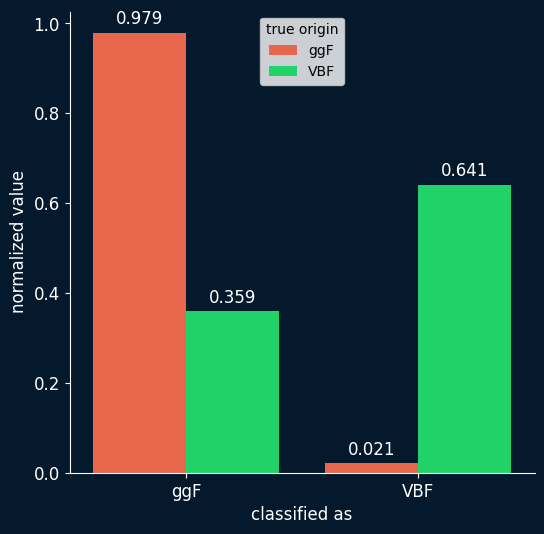

In [67]:
plot_confusion_barras(matriz)

### COMO LO HACEN EN TESIS

In [68]:
# modifico df_all para aplicar ml
# df_cortes_2 = df_all_cut
# df_cortes_2 = df_cortes_2.droplevel('df_name')
# df_cortes_2 = df_cortes_2.drop(['njet30', 'scale1fb', 'intLumi'], axis=1) # omito njet30, intlumi y scale1f
# df_cortes_2 = df_cortes_2.reset_index(level='origin')
# df_cortes_2 = pd.get_dummies(df_cortes_2, columns=['origin'], dtype=int)

# # creo los 2 filtros para vbf, si ambos son ciertos, es vbf (1) si no, no es vbf (0)
# filtro_MET = df_cortes_2["MET"] >= 225000
# filtro_mjj = df_cortes_2["mjj"] >= 1000000
# filtro_MET_inv = df_cortes_2["MET"] <= 225000
# filtro_mjj_inv = df_cortes_2["mjj"] <= 1000000
# df_cortes_2['pred_VBF'] = np.where(filtro_MET & filtro_mjj, 1, 0)
# df_cortes_2['pred_ggF'] = np.where(filtro_MET_inv & filtro_mjj_inv, 1, 0)

# df_cortes_2


In [69]:
# hago la matriz

# TRUE POSITIVE
# TP_VBF = df_cortes_2[(df_cortes_2["origin_VBF"] == 1) & (df_cortes_2["pred_VBF"] == 1)].count()
# TP_ggF = df_cortes_2[(df_cortes_2["origin_ggF"] == 1) & (df_cortes_2["pred_ggF"] == 1)].count()

In [70]:
from sklearn.metrics import f1_score
f1_score(df_cortes["origin_VBF"], df_cortes["pred_VBF"])

0.7514428635586176